---
title: "The Condorcet Jury Theorem and Democratic Rationality"
subtitle: "Sensitivity Analysis of Failure Conditions"
categories: ["theory", "simulation", "causal inference", "sensitivity analysis"]
keep-ipynb: true
self-contained: true
draft: false
toc: true
execute: 
  freeze: auto 
  execute: true
  eval: true
jupyter: applied-bayesian-regression-modeling-env
image: 'Independent_voter_errors_correlation.png'
author:
    - url: https://nathanielf.github.io/
    - affiliation: PyMC dev
citation: true
---


# The Legibility Trap: Contemptible Familiarity

Decision making in the modern corporation faces a paradox. On the surface, a smooth-running machine optimized for predictable outcomes. In practice, a careful balance between genuine risk assessment and the familiar processes that make investors feel confident and executives feel in control. But when familiar process becomes sacred process, something breaks: reasonable bets give way to bankable certainty, and accountability dissolves into alignment.

To the investment analyst and the private equity partner, "unfamiliarity" is unquantifiable risk. They demand a recognizable org chart, a standardized "Agile" workflow, and a set of "Core Values" that could be swapped between a pet-food startup and a sovereign wealth fund without anyone noticing. __This is the cult of Legibility__. Borrowing from James C. Scott’s _Seeing Like a State_, we see that when central authorities cannot understand a complex, organic system, they flatten it. They replace the wild, high-information "forest" of human talent with a "plantation" of identical, predictable units.

When you optimize primarily for the gaze of the outsider or conformity with precedent, you risk dulling your workforce's most valuable asset: their ability to see things differently. In our quest for "alignment" and adherence to legible standards, we can inadvertently destroy the only thing that makes a group smarter than an individual: _the generative friction of our differences._

What makes this pattern so difficult to resist is that it isn't purely imposed from above. We participate willingly; it is what Thi Nguyen calls "Value Capture". In the rough ground of reality it's genuinely hard to gauge quality, but in the planned organization we have metrics: 'Alignment,' 'Velocity,' and 'Team Spirit'. We trade the rich but murky value of truth-seeking for the thin but legible value of metric-meeting. We do so eagerly—not because we're foolish, but because legibility confers real benefits: clearer communication, easier justification, visible contribution. We adopt the value of the corporation as our own, and so short-circuit collective learning. 

But "miracle" of collective intelligence is a generative process that requires diversity. It requires that we be wrong in different directions so that, in the aggregate, we might be right. By smoothing out the "noise" of individual culture and opinion, we break the statistical engine that makes democracy and decentralization work. We break the statistical engine of collective intelligence: The Condorcet Jury Theorem.


## Do as I say, Not what I do.

Investors are among the world's most fervent believers in the power of diversification. They know that to survive a volatile market, they must hedge their bets across uncorrelated assets. Yet while the investor hedges in the aggregate, they need each subordinate company to appear as a single, comparable unit on a spreadsheet. They abstract away the details of any individual firm, eliminating the local variance in their portfolio view. They want each firm to be "aligned," "standardized," and "legible." In doing so, they incentivise a surface homogeneity that can propagate inward. The firms in their portfolio stop asking, 'Is this the right decision?' and start asking, 'Does this decision look aligned to the investor's model?' or "Are our peers doing the same?" The macro consequences of such mimicry are still being felt today, many years after the financial crisis of 2008.

The Condorcet Jury Theorem (CJT) is the mathematical foundation of this drive for diversification. It shows that if you have a group of independent actors who are minimally competent (i.e. $p > 0.5$ of being correct on binary decisions), then the probability of the majority being correct approaches 100% as the group size grows. There is real value in diversity when deployed well. But it's brittle, and many corporate "best practices"—however well-intentioned—can inadvertently undermine it.

::: {.callout-important}
## Deconstructing the Organizational Short-Circuit

In this post, we move beyond the idealized "spreadsheet" view of decision-making to understand why modern organizations often fail in lockstep. We will:

* **Revisit the Condorcet Miracle**: Define the mathematical preconditions for collective intelligence and identify where corporate "best practices" begin to subvert them.
* **Simulate Institutional Gravity**: Use a hierarchical Bayesian model to isolate how individual skill, systemic case difficulty, and organizational "blocks" compete for influence over the final vote.
* **Run the Post-Mortem**: Use Posterior Predictive Checks (PPC) to visualize how standardized cultures create an "accuracy ceiling" that remains stagnant even as the group size grows.
* **Bridge Theory to Philosophy**: Connect the statistical reality of correlated error to **James C. Scott’s** "Legibility" and **C. Thi Nguyen’s** "Value Capture".
:::

#### Setup

To understand how legibility short-circuits learning, we need a way to build a "company" from the ground up and stress-test its decision-making. Our simulation function, `simulate_jury_data`, is the generative heart of this piece. It doesn’t just create random numbers; it creates a world where we can toggle the parameters of Generative Friction.


In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

np.random.seed(42)

# Configuration
N_CASES = 50
N_JURORS = 15
JURY_SIZES = [3, 5, 7, 10, 15]
BLOCK_ID = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

### Data Generation and the Ground Truth

In a healthy system, learning happens in the gaps between different perspectives. But in a "legible" system, those gaps are closed. Our simulation allows us to model this across three dimensions


In [2]:
def simulate_jury_data(n_cases, n_jurors, true_p=0.65, true_discrimination=0.5, 
                       block_id=None, true_sigma_block=1.2):
    """
    Simulate jury voting data with optional block effects.
    
    Parameters:
    -----------
    n_cases : int
        Number of cases to judge
    n_jurors : int
        Number of jurors
    true_p : float
        Average competence (probability of correct vote)
    true_discrimination : float
        Standard deviation of competence in logit space
    block_id : array, optional
        Group membership for each juror (enables faction effects)
    true_sigma_block : float
        Standard deviation of block effects
        
    Returns:
    --------
    votes : (n_cases, n_jurors) array
        Binary voting matrix
    p_jurors : (n_jurors,) array
        True competence of each juror
    true_states : (n_cases,) array
        Ground truth for each case
    """
    true_states = np.random.binomial(1, 0.5, n_cases)
    
    # Simulate heterogeneous competencies in logit space
    logit_p_jurors = np.random.normal(
        np.log(true_p / (1 - true_p)), 
        true_discrimination, 
        n_jurors
    )
    
    # Add block effects if specified
    if block_id is not None:
        n_blocks = len(np.unique(block_id))
        block_effect = np.random.normal(1, true_sigma_block, n_blocks)
        logit_p_jurors += block_effect[block_id]
    
    p_jurors = 1 / (1 + np.exp(-logit_p_jurors))
    
    # Generate votes
    votes = np.zeros((n_cases, n_jurors))
    for i in range(n_cases):
        for j in range(n_jurors):
            prob = p_jurors[j] if true_states[i] == 1 else 1 - p_jurors[j]
            votes[i, j] = np.random.binomial(1, prob)
    
    return votes, p_jurors, true_states

# Generate our first dataset: simple case without blocks
votes, p_jurors, true_states = simulate_jury_data(N_CASES, N_JURORS)

print(f"Data simulated: {N_CASES} cases, {N_JURORS} jurors")
print(f"True average competence: {p_jurors.mean():.3f}")
majority = (votes.mean(axis=1) > 0.5) 
print(f"Majority vote accuracy: {np.mean(majority == true_states):.3f}")

Data simulated: 50 cases, 15 jurors
True average competence: 0.633
Majority vote accuracy: 0.840


Here how our data generating process encodes a baseline degree of juror competence. On any yes/no question we've ensured that the average juror has $(p \sim N(.65, \sigma_{disc}))$ chance of getting the right answer. The $\sigma_{disc}$ determines the range of individual skill in the population. We've then asked each juror to cast their vote on 50 decisions.

## Sensitivity to Prior Beliefs About Competence

In this model, we treat every employee as an interchangeable unit. We assume there are no factions, no "weird" outliers, and no cases that are harder than others. More important than that is the key is the requirement of conditional independence. No two people are "thinking alike" because of their shared training or culture; they are only "aligned" because they are all seeing the same Truth. This model (Model 1) defines the idealized world of the Condorcet Jury Theorem. Our first sensitivity analysis asks: **how much do our conclusions depend on our prior beliefs about juror competence?** 


In [3]:
# Define prior specifications
prior_specs = {
    'weakly_informative': {
        'alpha': 3, 'beta': 2, 
        'desc': 'Weakly informative (centered at 0.6)'
    },
    'strong_competence': {
        'alpha': 10, 'beta': 3, 
        'desc': 'Strong prior (p ~ 0.76)'
    },
    'barely_competent': {
        'alpha': 6, 'beta': 5, 
        'desc': 'Skeptical prior (p ~ 0.55)'
    },
    'incompetent': {
        'alpha': 5, 'beta': 10, 
        'desc': 'Incompetent prior (p ~ 0.33)'
    },
}

To perform our sensitivity analysis, we test four different "Corporate Climates." These represent the level of faith an organization has in its own internal competence. When a corporate decision leads to disaster, the post-mortem almost always focuses on competence. The diagnosis is usually that the "wrong people were in the room" or that the team lacked "domain expertise." This focus on individual skill is a convenient fiction for the investor class; it suggests that the organizational structure is fine, it just needs better "units."

We'll see that there are legitimate reasons to worry about individual incompetence for collective decision making. But you need to achieve a critical mass of incompetence for consequential error. In most cases marginal incomptence within an organisation rarely breaks the corporate mechanism. As long as those errors are independent—as long as the "incompetent" people are failing in their own unique, "weird" ways—the majority will still find the truth. The high-performers provide the signal, and the low-performers provide "white noise" that cancels itself out.

### Model 1: The Classical Condorcet Jury Model

Let $T_i \in \{0,1\}$ denote the true state of case $i = 1,\dots,N$, with
$$
T_i \sim \text{Bernoulli}(0.5).
$$

Each juror $j = 1,\dots,J$ casts a binary vote $V_{ij} \in \{0,1\}$.
Conditioned on the truth, all jurors share a common probability of voting correctly:
$$
\Pr(V_{ij} = T_i \mid p) = p, \qquad p > \tfrac{1}{2}.
$$

Equivalently, the likelihood may be written as:
$$
V_{ij} \mid T_i, p \sim
\begin{cases}
\text{Bernoulli}(p) & \text{if } T_i = 1, \\
\text{Bernoulli}(1-p) & \text{if } T_i = 0.
\end{cases}
$$

This model imposes three strong assumptions:

1. **Exchangeability across jurors**: all jurors are equally competent.
2. **Exchangeability across cases**: all cases are equally difficult.
3. **Conditional independence**:
$$
V_{ij} \perp V_{ik} \mid T_i, p.
$$

These assumptions define the idealized world in which the Condorcet Jury Theorem applies.


In [4]:
def fit_base_condorcet_model(votes, prior_spec, n_cases=N_CASES):
    """
    Fit basic Condorcet model with specified prior on competence.
    
    This model assumes:
    - All jurors have identical competence p
    - Votes are conditionally independent given the truth
    - Equal prior probability for guilty/not guilty
    """
    with pm.Model() as model:
        # SENSITIVITY PARAMETER: Prior on competence
        p = pm.Beta('p', alpha=prior_spec['alpha'], beta=prior_spec['beta'])
        
        # Latent true state of each case
        true_state = pm.Bernoulli('true_state', p=0.5, shape=n_cases)
        
        # Voting probability depends on true state
        vote_prob = pm.Deterministic('vote_prob', pm.math.switch(
            pm.math.eq(true_state[:, None], 1), p, 1 - p
        ))
        
        pm.Bernoulli('votes', p=vote_prob, observed=votes)
        
        # Posterior predictive: majority vote accuracy for different jury sizes
        for size in [3, 7, 15]:
            votes_sim = pm.Bernoulli(f'sim_votes_{size}', p=p, shape=size)
            pm.Deterministic(
                f'majority_correct_{size}',
                pm.math.sum(votes_sim) > size / 2
            )
        
        # Sample
        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(2000, tune=1000, random_seed=42,
                              target_accept=0.95, return_inferencedata=True))
        idata.extend(pm.sample_posterior_predictive(idata))
    
    return idata, model

The key property of the model we want to probe is how the accuracy of the majority vote evolves as we incorporate more jurors in the vote. The stressor we apply to test the system is to gauge how this accuracy evolve with degrees of population competence.
$$
p \sim \text{Beta}(\alpha, \beta).
$$

No assumptions about independence or exchangeability are altered. Instead, this model makes explicit the epistemic commitment that the Condorcet theorem leaves implicit: jurors are often assumed to be better than random *a priori*. You must hire well so that the average for each employee has a better than coin-flip chance of accuracy. This modest requirement is all we require to ensure collective accuracy, under the conditions of the model. 


In [5]:
# | output: false
# Fit under all prior specifications
traces = {}
for prior_name, spec in prior_specs.items():
    print(f"\nFitting with {spec['desc']}...")
    idata, model = fit_base_condorcet_model(votes, spec)
    traces[prior_name] = idata
    traces[prior_name + '_model'] = model


Fitting with Weakly informative (centered at 0.6)...


Sampling: [p, sim_votes_15, sim_votes_3, sim_votes_7, true_state, votes]


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [p]


>BinaryGibbsMetropolis: [true_state, sim_votes_3, sim_votes_7, sim_votes_15]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [votes]


Output()

Sampling: [p, sim_votes_15, sim_votes_3, sim_votes_7, true_state, votes]



Fitting with Strong prior (p ~ 0.76)...


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [p]


>BinaryGibbsMetropolis: [true_state, sim_votes_3, sim_votes_7, sim_votes_15]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [votes]


Output()

Sampling: [p, sim_votes_15, sim_votes_3, sim_votes_7, true_state, votes]



Fitting with Skeptical prior (p ~ 0.55)...


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [p]


>BinaryGibbsMetropolis: [true_state, sim_votes_3, sim_votes_7, sim_votes_15]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [votes]


Output()

Sampling: [p, sim_votes_15, sim_votes_3, sim_votes_7, true_state, votes]



Fitting with Incompetent prior (p ~ 0.33)...


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [p]


>BinaryGibbsMetropolis: [true_state, sim_votes_3, sim_votes_7, sim_votes_15]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [votes]


Output()

Let's examine how our prior beliefs influence prediction. We have sampled the majority votes under both our prior and the derived posterior distribution. We see how the accuracy of the majority vote grows with more voters when the priors about group competence is high. 


In [6]:
def extract_estimates(traces, prior_specs, jury_sizes=[3, 7, 15], stage='prior'):
    """Extract majority accuracy estimates from traces."""
    ests = {}
    for prior_name in prior_specs.keys():
        estimates = []
        for size in jury_sizes:
            p = traces[prior_name][stage][f'majority_correct_{size}'].mean().item()
            estimates.append(p)
        ests[prior_name] = estimates
    
    return pd.DataFrame(
        ests, 
        index=[f'Correct % for Majority of {s}' for s in jury_sizes]
    )

# Compare prior and posterior estimates
prior_estimates = extract_estimates(traces, prior_specs, stage='prior')
posterior_estimates = extract_estimates(traces, prior_specs, stage='posterior')

print("\n" + "="*70)
print("PRIOR ESTIMATES")
print("="*70)
print(prior_estimates)

print("\n" + "="*70)
print("POSTERIOR ESTIMATES (AFTER SEEING DATA)")
print("="*70)
print(posterior_estimates)


PRIOR ESTIMATES
                              weakly_informative  strong_competence  \
Correct % for Majority of 3                0.614              0.856   
Correct % for Majority of 7                0.642              0.908   
Correct % for Majority of 15               0.648              0.958   

                              barely_competent  incompetent  
Correct % for Majority of 3              0.546        0.256  
Correct % for Majority of 7              0.558        0.202  
Correct % for Majority of 15             0.568        0.138  

POSTERIOR ESTIMATES (AFTER SEEING DATA)
                              weakly_informative  strong_competence  \
Correct % for Majority of 3               0.5380           0.620250   
Correct % for Majority of 7               0.5485           0.667125   
Correct % for Majority of 15              0.5620           0.727750   

                              barely_competent  incompetent  
Correct % for Majority of 3           0.475250     0.381875  


However, we can also see how the aggregation of incompetent opinion tends towards incorrect. 


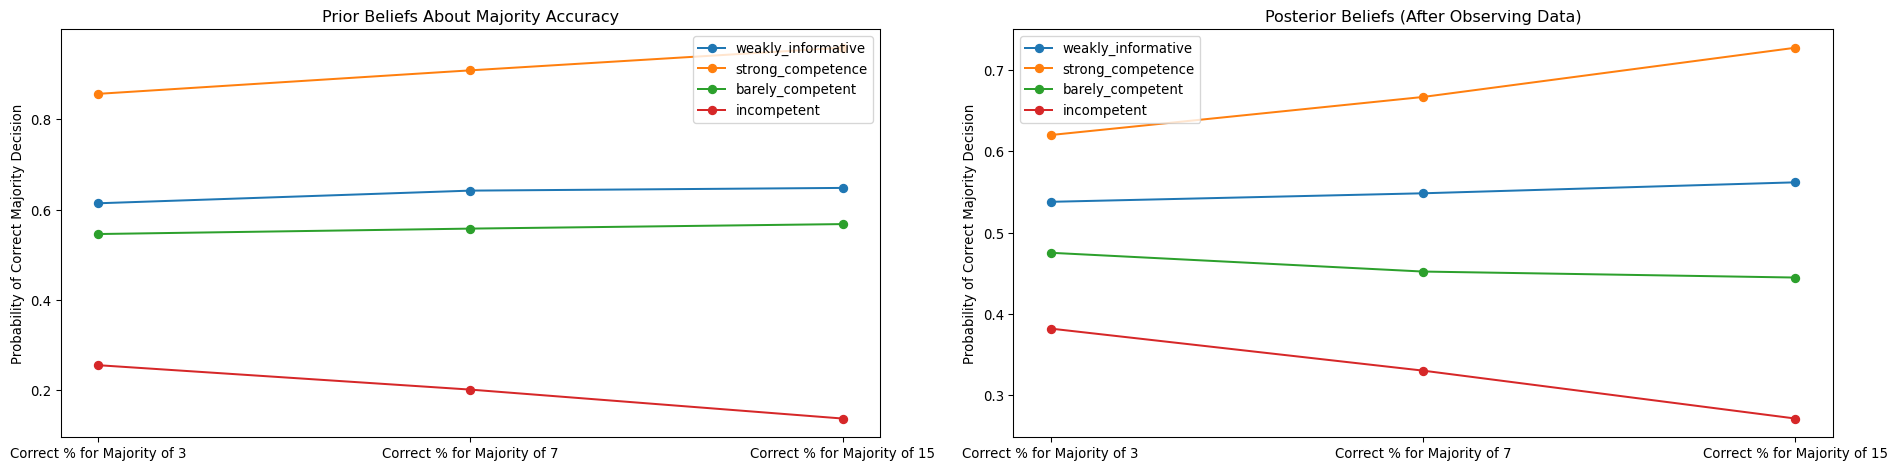

In [7]:
# Visualize the shift from prior to posterior
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

for prior_name in prior_specs.keys():
    axs[0].plot(prior_estimates.index, prior_estimates[prior_name], 
                label=prior_name, marker='o')
    axs[1].plot(posterior_estimates.index, posterior_estimates[prior_name], 
                label=prior_name, marker='o')

axs[0].legend()
axs[1].legend()
axs[0].set_title("Prior Beliefs About Majority Accuracy")
axs[1].set_title("Posterior Beliefs (After Observing Data)")
axs[0].set_ylabel("Probability of Correct Majority Decision")
axs[1].set_ylabel("Probability of Correct Majority Decision")

plt.tight_layout()
plt.show()

You cannot avoid the requirement of minimum competence in the jury pool if you hope for collective wisdom. But more strikingly, when we have even modest competence, the aggregation of votes quickly converges towards high accuracy. This is exactly the finding of Condorcet's Jury Theorem. 

::: {.callout-important}
## Formal Statement: The Condorcet Jury Theorem

Let a group of $n$ independent individuals (a "jury") be tasked with choosing between two outcomes, one of which is "correct." Let $p$ represent the probability of any single individual making the correct choice. The theorem consists of two parts:

1.  **The Competence Requirement:** If $p > 0.5$, then the probability that a majority of the group makes the correct choice is greater than $p$.
2.  **The Asymptotic Result:** As $n \to \infty$, the probability that the majority choice is correct approaches $1$.

Conversely, if $p < 0.5$, increasing the size of the jury only increases the probability that the group will arrive at the *wrong* conclusion, with that probability approaching $1$ as $n$ grows.
:::

This mathematical law is the 'efficiency' that the investor class is buying. You might look at this theorem and see a guarantee: as long as we hire 'competent' people ($p > 0.5$) and align them, we can't lose. But the theorem has a hidden poison pill. It relies entirely on independent errors, and we know that competence isn't uniform. This pulls us in two ways: (1) management panic over hiring standards and (2) fostering diversity in the employee base. We'll look at (1) next. 

## Individual Differences in Competence

The base Condorcet model assumes all jurors are identically competent. In reality, people vary in expertise, attention, and judgment. Let's model **heterogeneity** in juror competence. To gauge these effects we'll use a hierarchical model where individual competencies are drawn from a population distribution. The key sensitivity parameter is $\sigma$ (discrimination): how much do jurors differ?

#### Heterogeneous Juror Competence

We now relax the assumption that all jurors are equally competent. Each juror $j$ is assigned an individual probability of voting correctly:
$$
\text{logit}(p_j) = \mu + \sigma z_j, \qquad z_j \sim \mathcal{N}(0,1).
$$


For a fixed juror $j$, define the number of agreements with the majority:
$$
A_j = \sum_{i=1}^N \mathbb{1}\{V_{ij} = \text{majority}_i\}.
$$

Under the assumption that cases are exchangeable and votes are conditionally independent given $p_j$, we obtain the exact likelihood:

$$
A_j \mid p_j \sim \text{Binomial}(N, p_j).
$$

This is not an approximation. It is the marginal likelihood obtained by integrating over $$N$$ independent Bernoulli trials:
$$
\prod_{i=1}^N \text{Bernoulli}(V_{ij} \mid p_j)
\;\Longrightarrow\;
\text{Binomial}(A_j \mid N, p_j).
$$

This observation motivates a re-articuation of the condorcet model. The binomial phrasing is often easier to sample than the Bernoulli likelihood, so we shall switch to that model. Our next model uses a Binomial likelihood and  relies on two assumptions. We hold fixed the exchangeability across the cases and we rely on sufficiency of the count statistic. Once jurors are treated as stable measurement instruments, their entire voting history becomes a single aggregated observation. 

### Model 2: Varying Competence


In [8]:
def fit_hierarchical_model(votes, n_jurors, discrimination_prior):
    """
    Fit hierarchical model with individual variation in competence.
    
    Model structure:
    - μ: population mean competence (in logit space)
    - σ: population standard deviation (SENSITIVITY PARAMETER)
    - Each juror has individual competence drawn from N(μ, σ)
    
    We use non-centered parameterization for better sampling.
    """
    majority_votes = (votes.mean(axis=1) > 0.5).astype(int)
    agreements_per_juror = np.array([
        (votes[:, j] == majority_votes).sum() for j in range(n_jurors)
    ])
    
    with pm.Model() as model:
        # Population-level parameters
        mu_logit_p = pm.Normal('mu_logit_p', mu=0.6, sigma=0.5)
        
        # KEY SENSITIVITY PARAMETER: individual discrimination
        sigma_logit_p = pm.HalfNormal(
            'sigma_logit_p', 
            sigma=discrimination_prior['sigma']
        )
        
        # Non-centered parameterization: logit_p = μ + σ * z
        z_juror = pm.Normal('z_juror', mu=0, sigma=1, shape=n_jurors)
        logit_p_juror = pm.Deterministic(
            'logit_p_juror', 
            mu_logit_p + sigma_logit_p * z_juror
        )
        p_juror = pm.Deterministic('p_juror', pm.math.invlogit(logit_p_juror))
        
        # Collapsed likelihood: count agreements with majority
        pm.Binomial('agreements', n=N_CASES, p=p_juror, 
                   observed=agreements_per_juror)
        
        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(1000, tune=2000, random_seed=42,
                              target_accept=0.95, return_inferencedata=True,
                              idata_kwargs={"log_likelihood": True}))
        idata.extend(pm.sample_posterior_predictive(idata))
    
    return idata, model


Again, we'll test a range of priors. But this time we'll push on the range of permissable competence in the jury pool. 


In [9]:
# | output: false

# Test three levels of discrimination
discrimination_priors = {
    'weak_discrimination': {
        'sigma': 0.5, 
        'desc': 'Weak discrimination (σ ~ 0.5)'
    },
    'moderate_discrimination': {
        'sigma': 1.0, 
        'desc': 'Moderate discrimination (σ ~ 1)'
    },
    'strong_discrimination': {
        'sigma': 2.0, 
        'desc': 'Strong discrimination (σ ~ 2)'
    },
}

traces_discrimination = {}
for prior_name, spec in discrimination_priors.items():
    print(f"\nFitting with {spec['desc']}...")
    idata, model = fit_hierarchical_model(votes, N_JURORS, spec)
    traces_discrimination[prior_name] = idata
    traces_discrimination[prior_name + '_model'] = model

Sampling: [agreements, mu_logit_p, sigma_logit_p, z_juror]


Initializing NUTS using jitter+adapt_diag...



Fitting with Weak discrimination (σ ~ 0.5)...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_logit_p, sigma_logit_p, z_juror]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


Sampling: [agreements]


Output()

Sampling: [agreements, mu_logit_p, sigma_logit_p, z_juror]


Initializing NUTS using jitter+adapt_diag...



Fitting with Moderate discrimination (σ ~ 1)...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_logit_p, sigma_logit_p, z_juror]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


Sampling: [agreements]


Output()

Sampling: [agreements, mu_logit_p, sigma_logit_p, z_juror]


Initializing NUTS using jitter+adapt_diag...



Fitting with Strong discrimination (σ ~ 2)...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_logit_p, sigma_logit_p, z_juror]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


Sampling: [agreements]


Output()

Whereas in the previous model we observed each and every vote in the likelihood, here we're abstracting away from the particular and assuming their realised values are a consequece of latent structure; individual estimable competence. 


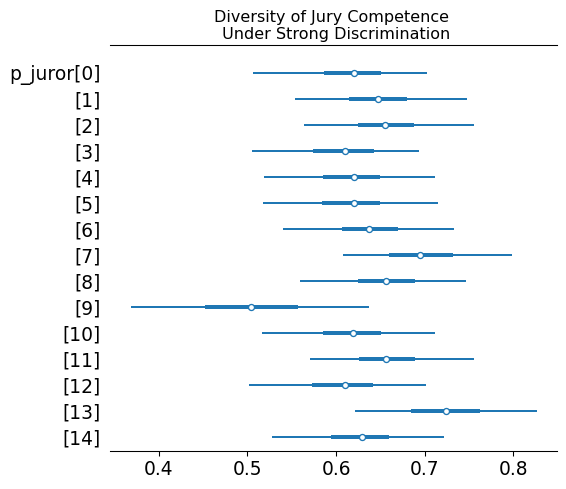

In [10]:
# Examine one of the fitted models
ax = az.plot_forest(traces_discrimination['strong_discrimination'], var_names=['p_juror'], combined=True)
ax[0].set_title("Diversity of Jury Competence \n Under Strong Discrimination");

By collapsing these observations into a Binomial distribution, we focus the model’s attention on the success rate of the collective. Paradoxically, by "throwing away" the individual case observations of the jurors, we force the model to account for the variance in the process itself.

### The Generative Process and Implied Votes 

It's for this reason we now rely on Posterior Predictive Sampling (PPC) to reconstruct these votes is that we are no longer just fitting a line to a set of points; we are simulating a generative process. To understand the implications of different discrimination levels, we need to simulate complete jury deliberations. In other words, we need to translate our individual voter's profile into votes. 
$$
V_{ij} \mid T_i, p_j \sim
\begin{cases}
\text{Bernoulli}(p_j) & \text{if } T_i = 1, \\
\text{Bernoulli}(1-p_j) & \text{if } T_i = 0.
\end{cases}
$$

This will then allow us to test for accuracy of the majority under different ranges of skill. The core insight is that we must forward sample to derive the voting profile of each individual.


In [11]:
def simulate_votes_from_competence(p_juror, n_cases, truth=None):
    """Generate votes given juror competencies and ground truth."""
    n_jurors = len(p_juror)
    if truth is None:
        truth = np.random.binomial(1, 0.5, size=n_cases)
    
    votes = np.zeros((n_cases, n_jurors), dtype=int)
    for i in range(n_cases):
        for j in range(n_jurors):
            prob = p_juror[j] if truth[i] == 1 else 1 - p_juror[j]
            votes[i, j] = np.random.binomial(1, prob)
    
    return truth, votes


To do so we'll define a number of helper functions below.


In [12]:
# | code-fold: true

def compute_diagnostics(votes, truth):
    """Compute suite of diagnostic metrics for jury performance."""
    majority = votes.mean(axis=1) > 0.5
    
    diagnostics = {
        'majority_accuracy': np.mean(majority == truth),
        'unanimity_rate': np.mean(
            (votes.sum(axis=1) == 0) | (votes.sum(axis=1) == votes.shape[1])
        ),
        'juror_agreement': np.mean(votes == truth[:, None], axis=0),
    }
    
    # Error correlation: do jurors make mistakes together?
    errors = votes != truth[:, None]
    if errors.var(axis=0).sum() > 0:
        diagnostics['error_corr'] = np.corrcoef(errors.T)
    else:
        diagnostics['error_corr'] = np.zeros((votes.shape[1], votes.shape[1]))
    
    return diagnostics


def majority_accuracy_by_size(votes, truth, jury_size):
    """Calculate accuracy for random sub-juries of given size."""
    n_cases, n_jurors = votes.shape
    correct = np.zeros(n_cases, dtype=int)
    
    for i in range(n_cases):
        jurors = np.random.choice(n_jurors, size=jury_size, replace=False)
        majority = votes[i, jurors].mean() > 0.5
        correct[i] = (majority == truth[i])
    
    return correct.mean()


def run_ppc_analysis(idata, n_cases, truth, jury_sizes=JURY_SIZES):
    """Run comprehensive posterior predictive checks."""
    p_juror_samples = (idata.posterior['p_juror']
                      .stack(sample=("chain", "draw")).values)
    n_jurors, n_samples = p_juror_samples.shape
    
    results = {
        'majority_acc': np.zeros(n_samples),
        'unanimity': np.zeros(n_samples),
        'error_corr': np.zeros((n_samples, n_jurors, n_jurors)),
        'accuracy_by_size': {k: np.zeros(n_samples) for k in jury_sizes}
    }
    
    for s in range(n_samples):
        _, votes = simulate_votes_from_competence(
            p_juror_samples[:, s], n_cases, truth
        )
        diag = compute_diagnostics(votes, truth)
        
        results['majority_acc'][s] = diag['majority_accuracy']
        results['unanimity'][s] = diag['unanimity_rate']
        results['error_corr'][s] = diag['error_corr']
        
        for k in jury_sizes:
            results['accuracy_by_size'][k][s] = (
                majority_accuracy_by_size(votes, truth, k)
            )
    
    return results


def summarize_ppc(ppc_results, jury_sizes=JURY_SIZES):
    """Create summary DataFrame from PPC results."""
    percentiles = [5, 50, 95]
    summaries = []
    
    for k in jury_sizes:
        summaries.append(np.percentile(
            ppc_results['accuracy_by_size'][k], percentiles
        ))
    
    df = pd.DataFrame(summaries).T
    df.columns = [f'majority_accuracy_{k}' for k in jury_sizes]
    df.index = [f'percentile_{p}' for p in percentiles]
    
    return df


def compare_prior_posterior(idata, n_cases, truth, jury_sizes=JURY_SIZES):
    """Compare prior and posterior predictive distributions."""
    results = {}
    
    for stage in ['prior', 'posterior']:
        p_samples = (getattr(idata, stage)['p_juror']
                    .stack(sample=("chain", "draw")).values)
        n_jurors, n_samples = p_samples.shape
        
        # Simplified PPC for comparison
        stage_results = {k: np.zeros(n_samples) for k in jury_sizes}
        for s in range(n_samples):
            _, votes = simulate_votes_from_competence(
                p_samples[:, s], n_cases, truth
            )
            for k in jury_sizes:
                stage_results[k][s] = majority_accuracy_by_size(votes, truth, k)
        
        results[stage] = summarize_ppc({'accuracy_by_size': stage_results}, 
                                      jury_sizes)
    
    return pd.concat(results, names=['stage', 'percentile'])

def plot_prior_posterior_comparison(df, title="Majority Accuracy"):
    """Plot prior vs posterior distributions."""
    x_values = JURY_SIZES
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for stage, color in [('prior', 'blue'), ('posterior', 'red')]:
        median = df.loc[(stage, 'percentile_50')]
        low = df.loc[(stage, 'percentile_5')]
        high = df.loc[(stage, 'percentile_95')]
        
        ax.plot(x_values, median, label=f'{stage.title()} Median', 
                color=color, marker='o')
        ax.fill_between(x_values, low, high, color=color, alpha=0.2,
                       label=f'{stage.title()} (5th-95th)')
    
    ax.set_title(title)
    ax.set_xlabel('Number of Jurors')
    ax.set_ylabel('Majority Accuracy')
    ax.set_xticks(x_values)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    return fig


Now let's apply this framework. We'll focus on the moderate discrimination case as it's most realistic:


In [13]:
# Analyze the moderate discrimination case
print(f"\n{'='*70}")
print(f"Analysis: {discrimination_priors['moderate_discrimination']['desc']}")
print('='*70)

comparison = compare_prior_posterior(
    traces_discrimination['moderate_discrimination'], 
    N_CASES, 
    true_states
)

comparison


Analysis: Moderate discrimination (σ ~ 1)


majority_accuracy_3  majority_accuracy_5  \
stage     percentile                                                
prior     percentile_5                  0.38                 0.36   
          percentile_50                 0.70                 0.74   
          percentile_95                 0.92                 0.96   
posterior percentile_5                  0.58                 0.62   
          percentile_50                 0.70                 0.74   
          percentile_95                 0.80                 0.84   

                         majority_accuracy_7  majority_accuracy_10  \
stage     percentile                                                 
prior     percentile_5                  0.32                  0.36   
          percentile_50                 0.78                  0.82   
          percentile_95                 0.98                  1.00   
posterior percentile_5                  0.66                  0.70   
          percentile_50                 0.78                  0.82   
          percentile_95                 0.88                  0.90   

                         majority_accuracy_15  
stage     percentile                           
prior     percentile_5                   0.28  
          percentile_50                  0.88  
          percentile_95                  1.00  
posterior percentile_5                   0.74  
          percentile_50                  0.86  
          percentile_95                  0.94

We still see convergen to the truth as we scale up the size of our majority even when we allow heterogeneous levels of skill in the voting population. The median prior and posterior estimates of accuracy are quite close, but we've significantly shrunk the uncertainty in our estimate. 


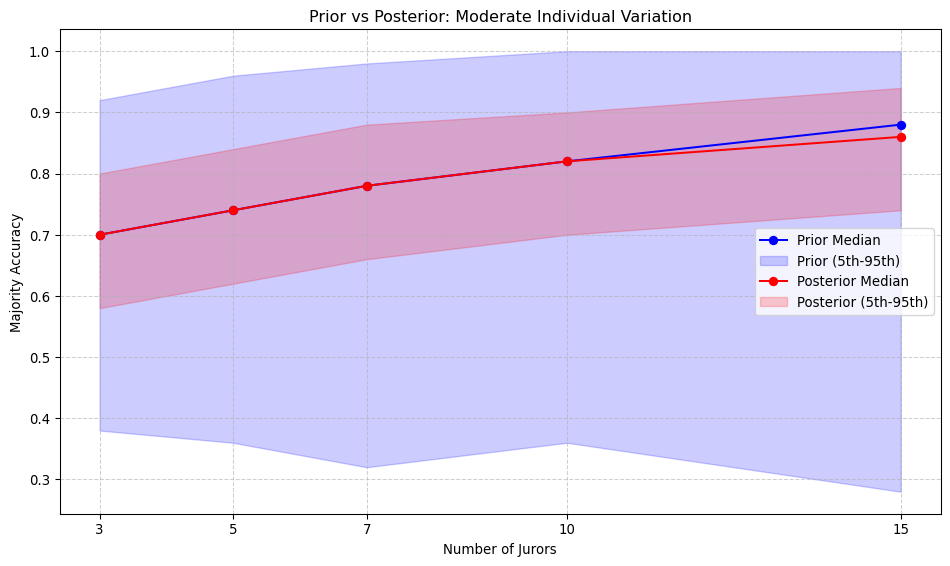

In [14]:
plot_prior_posterior_comparison(
    comparison, 
    title="Prior vs Posterior: Moderate Individual Variation"
);

The pattern is consistent across all discrimination levels: the data updates our beliefs, and larger juries show higher accuracy. The key question is whether errors remain independent.

#### Error Correlation Analysis

A critical assumption of Condorcet is **independence**: jurors make errors independently. Let's check this for our moderate discrimination model:


/Users/nathanielforde/mambaforge/envs/applied-bayesian-regression-modeling-env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nathanielforde/mambaforge/envs/applied-bayesian-regression-modeling-env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


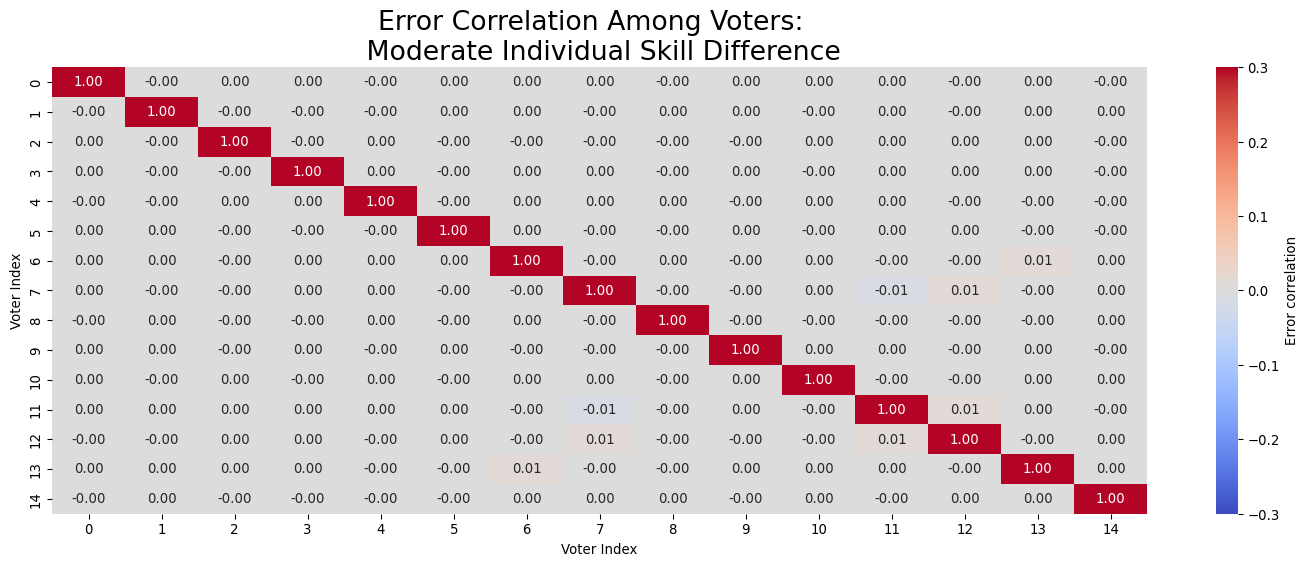

In [15]:
# | output: false
def plot_error_correlation_heatmap(ppc_results, title="Error Correlation"):
    """Plot mean error correlation matrix, handling NaN values properly."""
    all_corrs = ppc_results['error_corr']  # (n_samples, n_jurors, n_jurors)
    
    # Use nanmean to properly average across samples, ignoring NaNs
    mean_corr = np.nanmean(all_corrs, axis=0)
    
    # For cells that are still NaN (all samples were NaN), replace with 0
    mean_corr = np.nan_to_num(mean_corr, nan=0.0)
    mean_corr = np.round(mean_corr, 2)
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.heatmap(mean_corr, vmin=-.3, vmax=.3, cmap="coolwarm",
                square=False, cbar_kws={"label": "Error correlation"}, ax=ax, 
                annot=True, fmt=".2f")
    ax.set_title(title, fontsize=20)
    ax.set_xlabel("Voter Index")
    ax.set_ylabel("Voter Index")
    plt.tight_layout()
    return fig


def summarize_error_correlation(ppc_results):
    """Extract summary statistics from error correlation matrices."""
    corr = ppc_results['error_corr']
    n = corr.shape[1]
    
    off_diag = []
    for s in range(corr.shape[0]):
        mat = corr[s]
        # Extract upper triangle (excluding diagonal)
        upper_tri = mat[np.triu_indices(n, k=1)]
        # Only include non-NaN values
        valid_values = upper_tri[~np.isnan(upper_tri)]
        if len(valid_values) > 0:
            off_diag.extend(valid_values)
    
    off_diag = np.array(off_diag)
    
    if len(off_diag) == 0:
        return {
            'mean_off_diag': np.nan,
            'sd_off_diag': np.nan,
            'p95_abs_corr': np.nan,
        }
    
    return {
        'mean_off_diag': off_diag.mean(),
        'sd_off_diag': off_diag.std(),
        'p95_abs_corr': np.percentile(np.abs(off_diag), 95),
    }


ppc_moderate = run_ppc_analysis(
    traces_discrimination['moderate_discrimination'], 
    N_CASES, 
    true_states
)

fig = plot_error_correlation_heatmap(
    ppc_moderate, 
    title="Error Correlation Among Voters:  \n Moderate Individual Skill Difference"
);
fig.savefig("Independent_voter_errors_correlation.png")

![](Independent_voter_errors_correlation.png)


In [16]:
print("\nError Correlation Summary:")
summarize_error_correlation(ppc_moderate)


Error Correlation Summary:


{'mean_off_diag': np.float64(4.1269912183272494e-05),
 'sd_off_diag': np.float64(0.14293965923889015),
 'p95_abs_corr': np.float64(0.2792611296287719)}

**Key insight**: With heterogeneous competence alone, errors remain largely uncorrelated. The Condorcet theorem's independence assumption holds—so far. Which is to say that diverse workforces and varying degrees of competence do not inherently short-circuit the firm's ability to learn. 

## Shared Case Difficulty: When Everyone Fails Together
Now we introduce a critical violation: shared case-level effects. Some cases are genuinely harder, causing even competent jurors to fail together. This is the first structural break in the independence assumption—and it reveals why "hard problems" are exponentially harder for groups than the Condorcet theorem predicts.

### The Nature of Difficulty
In our models so far, we've assumed cases are exchangeable—each decision is equally difficult. But reality is messier. Consider:

- The obvious merger: Everyone agrees it's a good fit
- The ambiguous pivot: Market signals are mixed, competitive response is uncertain
- The moonshot bet: Technical feasibility is genuinely unknown

These aren't just decisions with different answers; they're decisions with different signal strength. When the signal is weak—when δᵢ is large in magnitude—even highly competent decision-makers will struggle. More importantly, they'll struggle in the same direction. This is fundamentally different from the heterogeneous competence we modeled earlier. Individual skill differences create uncorrelated noise: some people excel where others fail, and in aggregate, errors cancel out. Case difficulty creates correlated signal loss: when the evidence is weak, everyone's instruments fail simultaneously.

### The Mathematical Structure of Difficulty Shocks

We now introduce case-level difficulty effects:
$$
\delta_i \sim \mathcal{N}(0, \sigma_{\text{case}}).
$$

Votes are generated according to:
$$
\text{logit}\,\Pr(V_{ij} = T_i)
= \alpha_j + \delta_i.
$$

Notice what's happened to our model's architecture. Previously, each juror's vote depended only on their individual competence αⱼ and the truth Tᵢ. Now there's a third term—δᵢ—that affects every juror voting on case i. When δᵢ is large and negative, even our most competent jurors face degraded odds. When it's large and positive, even marginal performers temporarily shine.

### Structural Consequences of Error

Votes for the same case now share a common latent influence.
As a result:
$$
V_{ij} \not\!\perp V_{ik} \mid T_i, \alpha_j.
$$

conditioning on the truth is no longer sufficient to guarantee independence. Two jurors voting on the same hard case will make correlated errors, even if they're drawing on completely different expertise and making independent judgments. The theorem's guarantee—that majority accuracy approaches 100% with large groups—relied on errors being independent and therefore canceling out. But correlated errors don't cancel; they accumulate.

### Simulating Shared Case Shocks
To properly explore this, we need to do posterior predictive sampling that includes case difficulty in the generative model. We can't just fit a model with case effects and examine the posterior—we need to generate new votes under different difficulty regimes and see how the correlation structure changes.


In [17]:
# Simpler approach: directly simulate from posterior samples
def simple_case_difficulty_ppc(idata, n_cases_sim, sigma_case_values, 
                               true_states=None, n_draws=500):
    """
    Simplified PPC that samples logit_p from posterior then adds case effects.
    """
    if true_states is None:
        true_states = np.random.binomial(1, 0.5, size=n_cases_sim)
    
    # Get posterior samples
    logit_p_samples = (idata.posterior['logit_p_juror']
                      .stack(sample=("chain", "draw")).values)
    n_jurors, total_samples = logit_p_samples.shape
    
    # Randomly select n_draws samples
    sample_idx = np.random.choice(total_samples, size=n_draws, replace=False)
    logit_p_samples = logit_p_samples[:, sample_idx]
    
    results = {}
    
    for sigma_case in sigma_case_values:
        votes_array = np.zeros((n_draws, n_cases_sim, n_jurors), dtype=int)
        
        for s in range(n_draws):
            # Sample case difficulty effects
            delta_case = np.random.normal(0, sigma_case, size=n_cases_sim)
            
            for i in range(n_cases_sim):
                truth_i = true_states[i]
                sign = 1 if truth_i == 1 else -1
                
                # Apply case difficulty to all jurors
                logit_p_case = sign * logit_p_samples[:, s] + delta_case[i]
                p_case = 1 / (1 + np.exp(-logit_p_case))
                
                votes_array[s, i, :] = np.random.binomial(1, p_case)
        
        # Calculate diagnostics
        acc = []
        corrs = []
        
        for s in range(n_draws):
            majority = votes_array[s].mean(axis=1) > 0.5
            acc.append((majority == true_states).mean())
            
            errors = votes_array[s] != true_states[:, None]
            if errors.var(axis=0).sum() > 0:
                C = np.corrcoef(errors.T)
                corrs.append(C)
        
        corrs = np.stack(corrs) if corrs else np.zeros((1, n_jurors, n_jurors))
        off_diag = corrs[:, ~np.eye(n_jurors, dtype=bool)]
        
        results[sigma_case] = {
            'accuracy': acc,
            'mean_accuracy': np.mean(acc),
            'error_corr': corrs,
            'mean_corr': np.nanmean(off_diag),
            'median_corr': np.nanmedian(off_diag),
            'p95_abs_corr': np.nanpercentile(np.abs(off_diag), 95)
        }
    
    return results


print("="*70)
print("IMPACT OF SHARED CASE DIFFICULTY")
print("="*70)

sigma_values = [0.0, 0.2, 0.5, 1.0]
case_diff_results = simple_case_difficulty_ppc(
    traces_discrimination['weak_discrimination'],
    n_cases_sim=N_CASES,
    sigma_case_values=sigma_values,
    true_states=true_states,
    n_draws=500
)

for sigma in sigma_values:
    res = case_diff_results[sigma]
    print(f"\nσ_case = {sigma}")
    print(f"  Mean majority accuracy: {res['mean_accuracy']:.3f}")
    print(f"  Mean error correlation: {res['mean_corr']:.3f}")
    print(f"  Median error correlation: {res['median_corr']:.3f}")
    print(f"  95th %ile |correlation|: {res['p95_abs_corr']:.3f}")

IMPACT OF SHARED CASE DIFFICULTY



σ_case = 0.0
  Mean majority accuracy: 0.853
  Mean error correlation: 0.001
  Median error correlation: 0.000
  95th %ile |correlation|: 0.280

σ_case = 0.2
  Mean majority accuracy: 0.837
  Mean error correlation: 0.010
  Median error correlation: 0.010
  95th %ile |correlation|: 0.281

σ_case = 0.5
  Mean majority accuracy: 0.779
  Mean error correlation: 0.052
  Median error correlation: 0.051
  95th %ile |correlation|: 0.301

σ_case = 1.0
  Mean majority accuracy: 0.687
  Mean error correlation: 0.169
  Median error correlation: 0.169
  95th %ile |correlation|: 0.402


**Critical insight**: As case difficulty variance increases ($\sigma_{case}$), error correlation rises dramatically. At $\sigma_{case} = 1.0$, jurors make correlated errors with mean correlation around 0.15-0.17. This violates the independence assumption and **degrades majority accuracy** even with competent jurors.

The remaining question for organisational design: Are the patterns of correlation among jurors based on independent sources, or do they interact? We'll see that block effects and case difficulty can create a toxic synergy—when hard cases hit groups with shared biases, the correlation compounds and majority rule fails catastrophically. But what can we do about it?

## Voting Blocks and Improvement Programmes

Now we introduce the forces that will determine whether an organization can sustain collective wisdom or succumbs to coordinated failure: block effects ($\beta$) and treatment programmes ($\tau$). These structural additions represent opposing gravitational forces in a delicate equilibrium. Pull too hard in one direction and you get chaos; pull too hard in the other and you get lockstep failure.

### The Mathematical Structure: Competing Forces

We model each juror's vote as a negotiation between three forces:

$$
\text{logit}\,\Pr(V_{ij} = T_i) = \underbrace{\alpha_j}_{\text{individual skill}} + \underbrace{\beta_{b(j)}}_{\text{block gravity}} + \underbrace{\delta_i}_{\text{case difficulty}} - \underbrace{\tau_j \cdot Z_j}_{\text{treatment push}}
$$

Where:

- $\alpha_j$: Individual competence (heterogeneous across jurors)

- $\beta_b(j)$: Block effect for juror j's group (shared within blocks, creating correlation)

- $\delta_i$: Case difficulty (shared across all jurors for case i)
- $\tau_j \cdot Z_j$: Treatment effect (Z_j = 1 if juror j receives intervention, 0 otherwise)

The sign on the treatment term is critical: it *subtracts* from the combined logit. This means treatment is pushing *against* the combined force of individual tendency + block conformity + case difficulty. 

Think of it this way: Without treatment, a juror's probability of voting correctly is determined by their skill, modified by their block's shared bias, and further modified by how hard the case is. Treatment attempts to "decouple" them from their block's default position—to make them think independently even when their block would pull them in a particular direction.

If treatment works, $\tau$ should be positive: it reduces the influence of the $(\alpha + \beta + \delta)$ package and forces the juror to reconsider from first principles.

::: {.callout-note}
## A Note on Block Effects and Specialization

Block effects can arise from legitimate sources: engineers possess genuine domain expertise that others lack, sales teams have unique customer insights, executives have access to strategic information. These blocks may differ in average competence, and those differences can be entirely justified.

But for the Condorcet Jury Theorem, what matters is not whether one group is more competent than another—it's whether their errors are independent. A block of highly skilled specialists who share the same blind spots creates correlated errors that violate the theorem's assumptions. Even if Block A is objectively more accurate than Block B on average, if all members of Block A fail together on hard cases, the wisdom of crowds collapses.

This analysis explores these failure conditions: the point at which shared frameworks, training, or information access cause errors to cluster rather than cancel. The statistical machinery cannot distinguish "good blocks" from "bad blocks"—it can only detect correlation. And correlation, regardless of its source, is what breaks collective intelligence.
:::

### The Anatomy of Blocks: Epistemic Consolidation and Value Capture
In real organizations, people don't arrive at decisions in isolation. They cluster into groups that share:

- Functional training: All the engineers learned the same architecture patterns; all the MBAs learned the same strategy frameworks
- Information access: The sales team sees customer feedback the finance team never sees; executives receive filtered summaries while front-line workers see raw reality
- Incentive structures: Different departments optimize for different metrics, creating systematically different biases
- Social networks: People who talk to each other regularly start thinking alike, even without realizing it

These patterns promote an consolidation of epistemological standards. Members of a block don't just share surface characteristics; they share ways of knowing and hence ways of being wrong. We saw that case difficulty created correlation across the entire jury for specific cases. But block effects create persistent correlation within subgroups across all cases. This is structurally worse. And then when evidence is ambiguous and cases difficult, people fall back on their frameworks, and if everyone shares frameworks, everyone fails together. In this way case-difficulty and group-think interact to drive an organisation to overly simplified, but easily defensible heuristics.

> "Value capture happens when a person or group adopts an externally-sourced value as their own, without adapting it to their particular context... In value capture, we outsource the process of value deliberation. And, as with other forms of outsourcing, there is a trade-off...When we adopt those values, we gain access to readymade methods for justification" - Nguygen

The adoption of an external standard or metric can confer legitimacy, but also tends to favour an abstraction that ignore relevant detail. We lose focus on local context we make our goals legible beyond it. "We did it because everyone else was doing it" works until it doesn't. 

#### The Legibility Trap: Redux
Recall that investors demand "alignment" and "standardization". They want unified KPI systems, "Culture fit"-hiring and best-practices adoption, Common Tooling. These forces push us towards organisations towards consolidation of shared incentives, methods and cognitive practices. Not only can corporate values supplant your individual perspective, they do so at scale. Every legibility-seeking practice is a block-creating mechanism. By making the organization more "readable" to outsiders, you create the very correlations that break collective intelligence.

#### The Treatment Paradox
Pulling in the opposite direction. Organisations aren't static and leaders can intervene. They can run training programs, hire consultants, promote new processes and suggest or mandate resolution frameworks. The question is whether these interventions break group-think or reinforce it? One useful example is the pattern of "red-teaming" in software development. Before a major decision, you randomly assign people from each block to argue against their block's default position. This intervention creates divergent pressure. It doesn't eliminate block membership. Engineers remain engineers, but it forces block members to engage with perspectives that directly challenge their shared frameworks. The treatment pulls against block effects. Or so goes the theory.

## The Complete Model: Modeling the Push and Pull

We've now seen two opposing forces at work in organizational decision-making:

**The Pull Toward Legibility (Block Effects)**: Shared training, common frameworks, aligned incentives. These create β-blocks—groups who think alike not because they're incompetent, but because they've been optimized for coherence. This is the gravitational force that makes organizations manageable but epistemically fragile.

**The Push Toward Independence (Treatment Effects)**: Interventions designed to break people out of their default frameworks. Red-teaming exercises, devil's advocate assignments, cross-functional rotation, deliberately soliciting dissent. These are organizational attempts to restore the independence that the Condorcet theorem requires.

Our final model formalizes this tension. Block effects (β) pull jurors toward correlated errors. Treatment effects (τ) push them back toward independence. The question is whether deliberate intervention can overcome structural gravity—or whether the legibility trap is too strong to escape.


In [18]:
# | output: false
# Generate new data with block structure
votes_blocked, p_jurors_blocked, true_states_blocked = simulate_jury_data(
    N_CASES, N_JURORS, block_id=BLOCK_ID
)

def fit_full_model(votes, n_jurors, block_id, treatment_indicator,
    use_treatment=0):
    """
    Complete model with four sources of variation:
    1. Individual skill (α_j)
    2. Block/faction effects (β_block)
    3. Case difficulty (δ_case)
    4. Treatment Programme (tau)
    """
    majority_votes = (votes.mean(axis=1) > 0.5).astype(int)
    agreements_per_juror = np.array([
        (votes[:, j] == majority_votes).sum() for j in range(n_jurors)
    ])
    
    with pm.Model() as model:
        # Individual skill
        mu_alpha = 0
        sigma_alpha = pm.Exponential("sigma_alpha", lam=3.0)
        alpha_raw = pm.Normal("alpha_raw", 0.0, 1.0, shape=n_jurors)
        alpha_j = pm.Deterministic("alpha_j", mu_alpha + sigma_alpha * alpha_raw)
        
        # Block effects (ideological factions, info silos)
        n_blocks = len(np.unique(block_id))
        sigma_block = pm.HalfNormal("sigma_block", sigma=1.0)
        block_effect_raw = pm.Normal("block_effect_raw", mu=0.0, sigma=1.0, shape=n_blocks)
        block_effect = pm.Deterministic("block_effect", sigma_block * block_effect_raw)
        beta_block_j = block_effect[block_id]
        
        # Case difficulty (collapsed over cases)
        # Simplify:
        mu_case = pm.Normal("mu_case", mu=0.0, sigma=0.5)
        sigma_case = pm.HalfNormal("sigma_case", sigma=1.0)
        delta_bar = pm.Normal("delta_bar", mu=mu_case, sigma=sigma_case)

        # -----------------------------
        # Treatment effect (switchable)
        # -----------------------------
        tau = pm.Exponential("tau", 3.0, shape=N_JURORS)

        # convert to tensors to avoid shape surprises
        Z = pm.math.constant(treatment_indicator)
        s = pm.math.constant(use_treatment)

        treatment_term = pm.Deterministic('trt', s * Z * tau)
        
        # Combined model
        logit_p_correct = ((alpha_j + beta_block_j + delta_bar) - treatment_term)
        p_correct = pm.Deterministic("p_correct", 
                                    pm.math.sigmoid(logit_p_correct))
        
        # Collapsed likelihood
        pm.Binomial("agreements", n=N_CASES, p=p_correct, 
                   observed=agreements_per_juror)
        
        idata = pm.sample(2000, tune=2000, target_accept=0.99, 
                         return_inferencedata=True)
    
    return idata, model


print("\nFitting complete hierarchical model...")
idata_full, model_full = fit_full_model(votes_blocked, N_JURORS, BLOCK_ID,  treatment_indicator=np.zeros(N_JURORS), use_treatment=0)

treatment_assignment = np.ones(N_JURORS)
idata_full_trt, model_full_trt = fit_full_model(votes_blocked, N_JURORS, BLOCK_ID,  treatment_indicator=treatment_assignment, use_treatment=1)


Fitting complete hierarchical model...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [sigma_alpha, alpha_raw, sigma_block, block_effect_raw, mu_case, sigma_case, delta_bar, tau]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.


There were 38 divergences after tuning. Increase `target_accept` or reparameterize.


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [sigma_alpha, alpha_raw, sigma_block, block_effect_raw, mu_case, sigma_case, delta_bar, tau]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 15 seconds.


There were 37 divergences after tuning. Increase `target_accept` or reparameterize.


We fit two versions of the model against the same blocked data:

**Model 1: Natural State (Z = 0 for all jurors)**
This is the organization as it exists: blocks have formed through natural processes (hiring, training, cultural evolution), and no deliberate effort is made to break people out of their silos. All variance in voting patterns must be explained by individual skill, block membership, and case difficulty.

**Model 2: Intervention State (Z = 1 for all jurors)**
This represents an organization that has implemented a comprehensive independence-restoration program. Examples might include:

- **Red-teaming**: Before voting, randomly assign people to argue against their block's default position

- **Rotation**: Temporarily embed engineers in sales, finance in product

- **Structured dissent**: Require each block to produce an internal critic before voting

- **Anonymous voting**: Remove social pressure to conform to block consensus

The treatment indicator $Z_j = 1$ tells the model: "This juror has been subjected to an intervention designed to reduce their dependence on block-default thinking."

The question: Can such interventions meaningfully push against the gravity of legibility? Or does the correlation persist despite our best efforts?


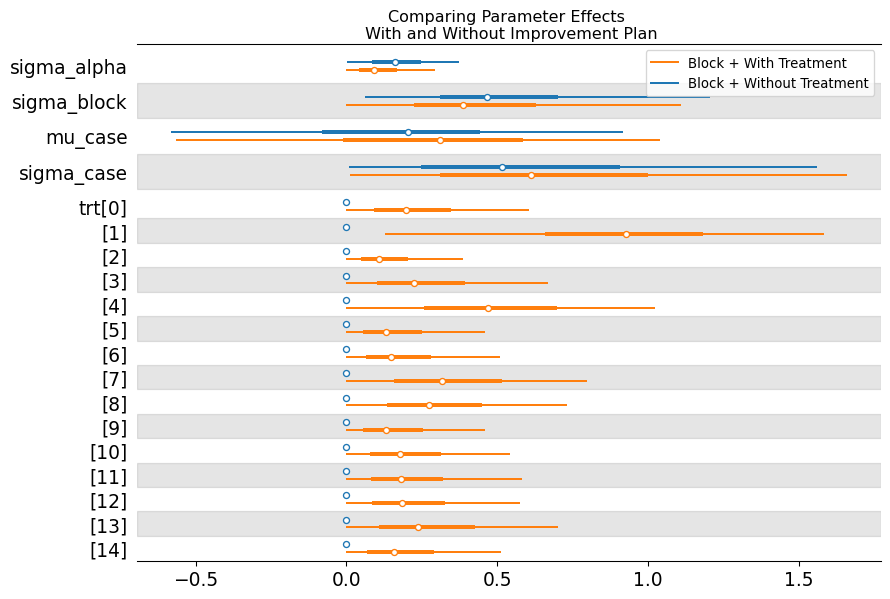

In [19]:
ax = az.plot_forest([idata_full, idata_full_trt], var_names=["sigma_alpha", "sigma_block", "mu_case", "sigma_case", "trt"], combined=True, model_names=['Block + Without Treatment', 'Block + With Treatment'], figsize=(10, 7))
ax[0].set_title("Comparing Parameter Effects \n With and Without Improvement Plan");


### What the Model Tells Us About Organizational Intervention

The forest plot reveals something uncomfortable: when we "turn on" treatment (Z = 1), the model doesn't conclude that block effects have weakened. Instead, it concludes that block effects must be *even stronger* than we thought.

Why? Because the voting patterns remain stubbornly correlated despite the presumed intervention. The Bayesian engine reasons backwards: "If treatment is supposed to push people toward independence, but I still see strong correlation in the data, then either (a) treatment doesn't work, or (b) the underlying block effects are so powerful that even treated jurors remain influenced."

The model chooses interpretation (b), allocating *more* variance to σ_block in the treatment model. This is the statistical signature of organizational inertia: interventions that look good on paper (red-teaming, rotation programs, diversity training) fail to break the fundamental correlation structure.

The treatment effect τ remains small or uncertain because the model cannot distinguish "treatment is working a little" from "blocks are just that strong." This is not a flaw in the model—it's an honest reflection of the data-generating process. If block effects are structural (shared information, shared incentives, shared training), surface-level interventions may not be enough.

## Posterior Predictive Checks for Complete Model

Fitting the model is only half the battle; the PPC allows us to simulate "new" decisions from the inferred organizational structure to see if the "Condorcet Miracle" survives the reality of corporate blocks. In our earlier model we saw majority accuracy march steadily toward $100\%$ as the jury size grew. Here, that progress hits a hard ceiling.


In [20]:
def run_ppc_full_model(idata, n_cases, true_states, block_id, 
                       jury_sizes=JURY_SIZES, n_draws=500):
    """
    PPC for complete model including block and case effects.
    Properly samples from posterior distribution.
    """
    # Extract posterior samples
    alpha_j = idata.posterior['alpha_j'].stack(sample=("chain", "draw")).values
    block_effect = idata.posterior['block_effect'].stack(sample=("chain", "draw")).values
    sigma_case = idata.posterior['sigma_case'].stack(sample=("chain", "draw")).values
    mu_case = idata.posterior['mu_case'].stack(sample=("chain", "draw")).values
    trt = idata.posterior['trt'].stack(sample=("chain", "draw")).values
    
    n_jurors = alpha_j.shape[0]
    total_samples = alpha_j.shape[1]
    
    # Randomly select n_draws samples
    sample_idx = np.random.choice(total_samples, size=min(n_draws, total_samples), 
                                 replace=False)
    n_draws = len(sample_idx)
    
    results = {
        'majority_acc': np.zeros(n_draws),
        'error_corr': np.zeros((n_draws, n_jurors, n_jurors)),
        'accuracy_by_size': {k: np.zeros(n_draws) for k in jury_sizes}
    }
    
    rng = np.random.default_rng(42)
    
    for idx, s in enumerate(sample_idx):
        # Sample case difficulty effects for this posterior draw
        delta_case = rng.normal(mu_case[s], sigma_case[s], size=n_cases)
        
        # Generate votes for each case
        votes = np.zeros((n_cases, n_jurors), dtype=int)
        
        for i in range(n_cases):
            truth_i = true_states[i]
            sign = 1 if truth_i == 1 else -1
            
            for j in range(n_jurors):
                # Combine individual skill + block effect + case difficulty
                logit_p = sign * (alpha_j[j, s] + block_effect[block_id[j], s]) + delta_case[i] + trt[j, s]
                p = 1 / (1 + np.exp(-logit_p))
                votes[i, j] = rng.binomial(1, p)
        
        # Compute diagnostics
        diag = compute_diagnostics(votes, true_states)
        results['majority_acc'][idx] = diag['majority_accuracy']
        results['error_corr'][idx] = diag['error_corr']
        
        for k in jury_sizes:
            results['accuracy_by_size'][k][idx] = (
                majority_accuracy_by_size(votes, true_states, k)
            )
    
    return results

The power of the hierarchical model lies in its ability to "partial out" exactly why a juror was wrong. In the vanilla model, an incorrect vote was simply "incompetence." Here, it is a structural outcome. To derive the vote profile of each individual, we have re-assembled the components we just decomposed. Forward sampling in this way allows us to see how the probability of correctness for any single voter is a negotiation between their own talent and the gravitational forces of the system they inhabit.


In [21]:
print("\nRunning posterior predictive checks for complete model...")
ppc_full = run_ppc_full_model(idata_full, N_CASES, true_states_blocked, 
                               BLOCK_ID, n_draws=500)

ppc_full_trt = run_ppc_full_model(idata_full_trt, N_CASES, true_states_blocked, 
                               BLOCK_ID, n_draws=500)

# Summarize accuracy by jury size
summary_full = summarize_ppc(ppc_full)
print("\n" + "="*70)
print("MAJORITY ACCURACY BY JURY SIZE (Complete Model)")
print("="*70)
summary_full


Running posterior predictive checks for complete model...



MAJORITY ACCURACY BY JURY SIZE (Complete Model)


,majority_accuracy_3,majority_accuracy_5,majority_accuracy_7,majority_accuracy_10,majority_accuracy_15
percentile_5,0.360,0.36,0.36,0.34,0.340
percentile_50,0.520,0.54,0.54,0.52,0.540
percentile_95,0.701,0.72,0.74,0.76,0.801


Notice how the increasing size of the voting block does not substantially improve on the accuracy. There is strong evidence of a plateau effect in the majority accuracy. The combination of new voters is not providing new information. This pattern is also unfortunately visible in our treatment model. 


In [22]:
summary_full_trt = summarize_ppc(ppc_full_trt)
print("\n" + "="*70)
print("MAJORITY ACCURACY BY JURY SIZE (Complete Model + Treatment)")
print("="*70)
summary_full_trt



MAJORITY ACCURACY BY JURY SIZE (Complete Model + Treatment)


,majority_accuracy_3,majority_accuracy_5,majority_accuracy_7,majority_accuracy_10,majority_accuracy_15
percentile_5,0.40,0.40,0.40,0.380,0.419
percentile_50,0.54,0.56,0.56,0.560,0.580
percentile_95,0.72,0.76,0.78,0.801,0.820


The allocation of a heterogenous treatment progromme was also not sufficient to break the block voting effects. 



ERROR CORRELATION SUMMARY (Complete Model)
mean_off_diag: 0.124
sd_off_diag: 0.175
p95_abs_corr: 0.425


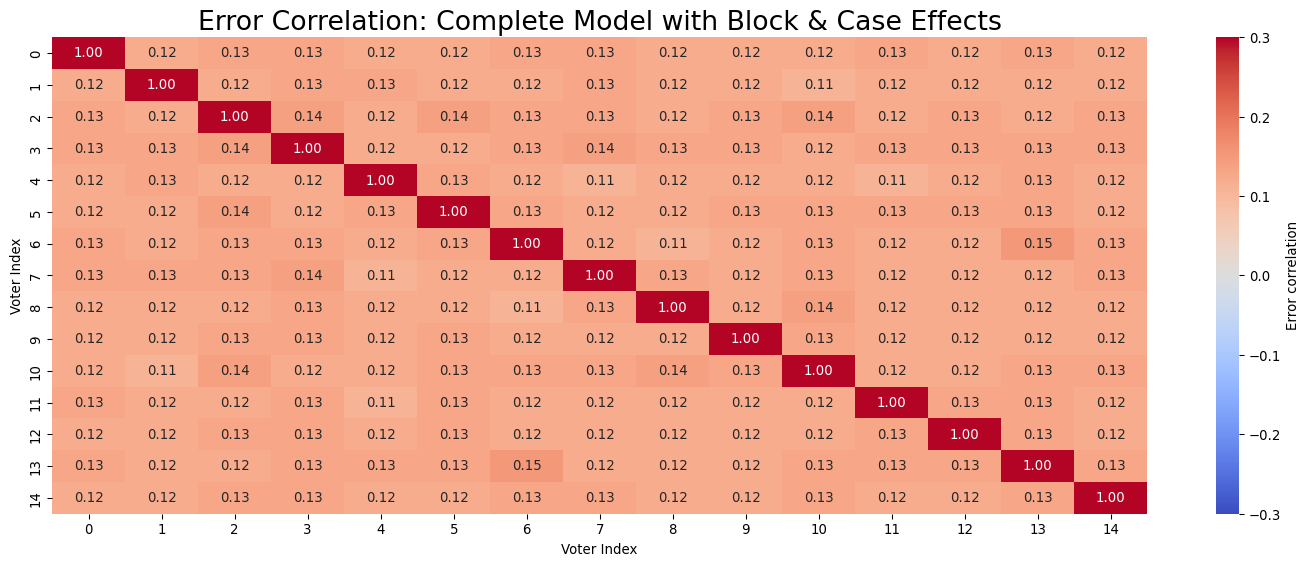

In [23]:
# Plot error correlations
plot_error_correlation_heatmap(
    ppc_full,
    title="Error Correlation: Complete Model with Block & Case Effects"
)

print("\n" + "="*70)
print("ERROR CORRELATION SUMMARY (Complete Model)")
print("="*70)
error_summary = summarize_error_correlation(ppc_full)
for key, value in error_summary.items():
    print(f"{key}: {value:.3f}")

Notice the structured patterns in the error correlation heatmap—jurors within the same block show correlated errors. This is the smoking gun: **block effects create dependencies that violate the independence assumption**.



ERROR CORRELATION SUMMARY (Complete Model)
mean_off_diag: 0.185
sd_off_diag: 0.173
p95_abs_corr: 0.475


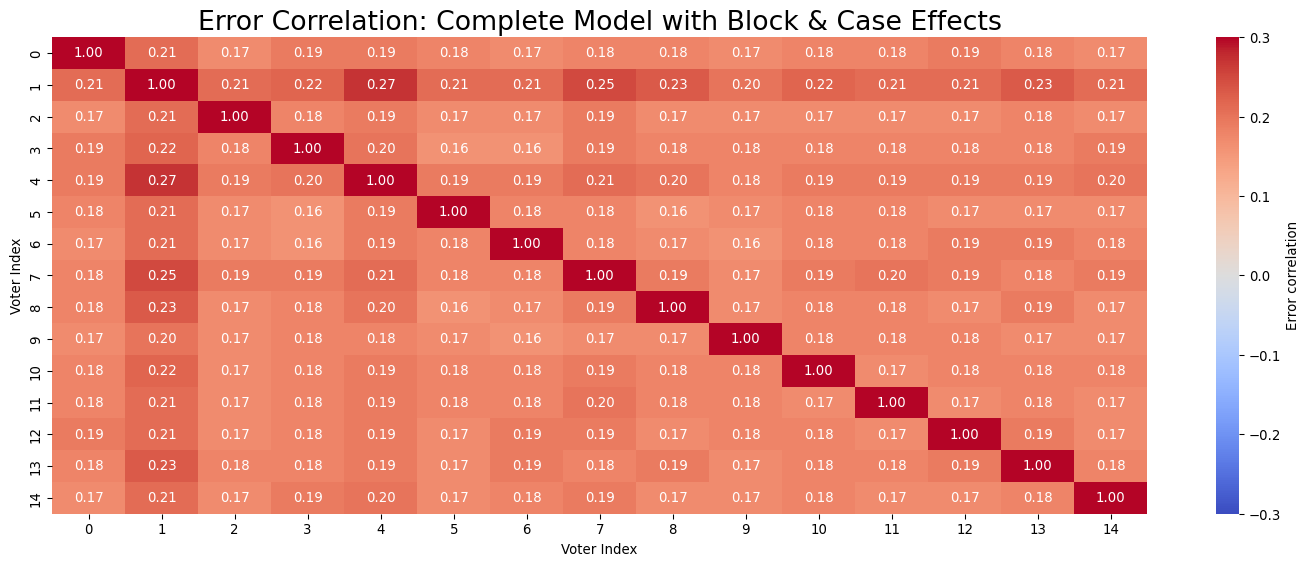

In [24]:
# Plot error correlations
plot_error_correlation_heatmap(
    ppc_full_trt,
    title="Error Correlation: Complete Model with Block & Case Effects"
)

print("\n" + "="*70)
print("ERROR CORRELATION SUMMARY (Complete Model)")
print("="*70)
error_summary = summarize_error_correlation(ppc_full_trt)
for key, value in error_summary.items():
    print(f"{key}: {value:.3f}")

While the correlation patterns change slightly, they remain high and reduce the effectiveness of the majority.

The treatment paradox captures the organizational dilemma in statistical form. Leaders genuinely try to foster independence: they hire for "cognitive diversity," they implement devil's advocate protocols, they rotate people across functions. These are the $\tau$ terms in our model—deliberate pushes against the pull of legibility.

But our posterior estimates suggest that these interventions often fail to overcome structural forces. The $\beta$ terms (block effects driven by shared training, information, and incentives) dominate the $\tau$ terms (deliberate interventions). This isn't because leaders are incompetent or uncommitted—it's because block formation is structural while treatment is episodic. You can send an engineer to shadow a sales call ($\tau$), but they return to an engineering team with engineering metrics, engineering promotion criteria, and engineering social networks ($\beta$). The gravitational field reasserts itself.

The model cannot tell us whether stronger interventions would work—whether, for instance, permanently breaking up blocks through forced cross-functional teams would restore independence. What it does tell us is that incremental, well-intentioned programs often aren't enough to overcome the correlation that legibility creates.

# Conclusions

A failure to properly instrumentalize values through appropriate proxy metrics hinders communication, cohesion and cooperation within and between organisations. And yet too crude an instrumentalization of value turns work from a compelling collective action project into a metric movement charade. Worse, it drives us to error and expected failure. 

The statistical breakdown of the Condorcet Jury Theorem is not an accident of poor corporate planning; it is the inevitable result of a fundamental tension in cooperative work. We are witnessing a persistent tug-of-war between two opposing gravitational forces:

- The Pull for Legibility (Scott): The necessary drive to make the organization understandable to the investor, the analyst, and the leader. This force creates the "blocks," the standardized workflows, and the shared cultures that allow thousands of people to move in the same direction.

- The Push for Agency (Nguyen): The individual’s resistance to Value Capture. This is the drive to maintain a unique, high-fidelity perspective on reality that hasn't been flattened by a KPI or a "Core Value."

When we let the pull for Legibility dominate entirely, we risk the "Contemptible Familiarity" of the over-optimized corporation. We get a system that is easy to manage on a spreadsheet or JIRA-board but potentially epistemically compromised. In the worst case: a group of 1,000 people with the collective wisdom of one, because they have all been trained to see the world through the same lens—and thus to share the same blind spots. This is the cardinal sin of "Value Capture". We have adopted the organization's simplified map of the world as our own, and in doing so, we have destroyed our ability to help the organization see.